#### 240701 Pseudo Smear Image Generation

In [1]:
base_repo = '/workspace/mnt/cluster/HDD/azuma/Hematology'

import gc
import cv2
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from PIL import Image
from glob import glob
from tqdm import tqdm
from scipy import stats

import sys
sys.path.append(base_repo+'/github/DigitalHematology')
from preprocessing import data_generator_instance as dgi

***
1. Background isolation
2. Fill the background with mean values
3. Add Gaussia noise to the background

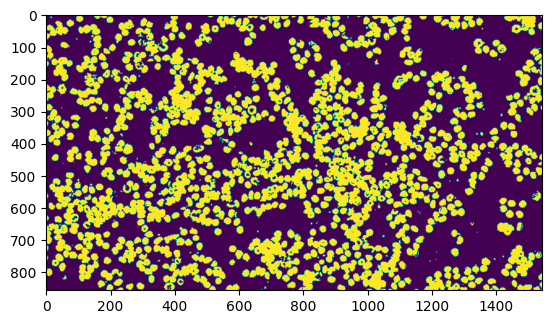

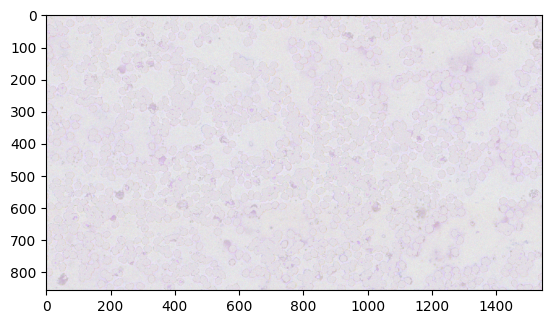

In [2]:
# %% Preprocessing
img_path = base_repo + '/datasource/Rat_DILI/240320_rat_GAL_CCl4/tmp_patches_raw/240421_patch_2.tif'
img = Image.open(img_path).convert("RGB")  # convert to gray scale
gray = Image.open(img_path).convert("L")  # convert to gray scale

# Otsu method
ret, bin_img = cv2.threshold(np.array(gray), 10, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
plt.imshow(bin_img)
plt.show()

# remove object area
img_array = np.array(img)
img_array[bin_img>0] = [0,0,0]

# Fill the background with mean values
mean_value = img_array[bin_img==0].mean(axis=0)  # array([227.02099423, 222.45661803, 230.05298658])
img_array[bin_img>0] = mean_value

# add Gaussian noise
mu = 0
sigma = 10
noise = np.random.normal(mu, sigma, img_array.shape) 

noisy_img = img_array.astype(np.float64) + noise
noisy_img = np.clip(noisy_img, 0, 255).astype(np.uint8)
plt.imshow(noisy_img)
plt.show()

***
##### 1. Affix red blood cells

222 cells have been collected.


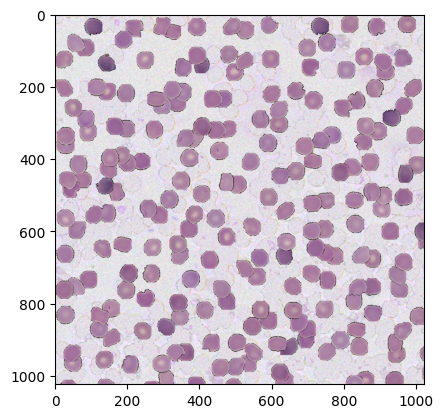

In [3]:
# Generate random seed list
def rand_ints_nodup(a, b, k):
    ns = []
    while len(ns) < k:
      n = random.randint(a, b)
      if not n in ns:
        ns.append(n)
    return ns

rbc_candi = sorted(list(glob(base_repo+'/datasource/Smear_Datasets/Kaggle_Malaria_Cell/Uninfected/C7NthinF*.png')))

random.seed(123)  # fix seed
# crop background and resize
corner = (random.randint(0,noisy_img.shape[0]-512),random.randint(0,noisy_img.shape[1]-512))
crop_img = noisy_img[corner[0]:corner[0]+512,corner[1]:corner[1]+512,:]
img = Image.fromarray(crop_img).resize((1024,1024))

# affix
n_iter = 5000
random_n_size = random.randint(200,400)  # RBC number
random_sets = rand_ints_nodup(0,n_iter,n_iter)
bg, label_matrix = dgi.gen_bg_single(rbc_candi,random_sets,bgH=1024,bgW=1024,sampleH=50,sampleW=50,n_iter=n_iter,n_cells=random_n_size,tol=55,bg=img)

assert label_matrix.min() == 0

# visualize
plt.imshow(bg)
plt.show()

***
##### 2. Affix white blood cells

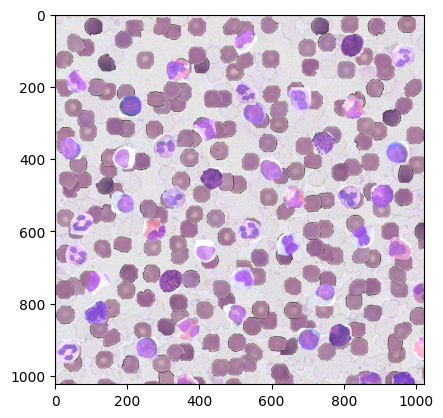

In [4]:
# %% Affix WBCs on the 
img_file_path = base_repo+'/datasource/Smear_Datasets/LISC Database/Main Dataset'
mask_file_path = base_repo+'/datasource/Smear_Datasets/LISC Database/Ground Truth Segmentation'

n_iter=1000
random.seed(123)
random_sets = rand_ints_nodup(0,n_iter,n_iter)

bg, label_matrix, pos_history, baso_label_list = dgi.affix_lisc(bg,random_sets,img_file_path,mask_file_path,cell_type='Baso',sampleH=65,sampleW=65,n_iter=n_iter,n_cells=10,tol=100,pos_history=None,label_matrix=label_matrix)
bg, label_matrix, pos_history, eosi_label_list = dgi.affix_lisc(bg,random_sets,img_file_path,mask_file_path,cell_type='eosi',sampleH=65,sampleW=65,n_iter=n_iter,n_cells=10,tol=100,pos_history=pos_history,label_matrix=label_matrix)
bg, label_matrix, pos_history, lymp_label_list = dgi.affix_lisc(bg,random_sets,img_file_path,mask_file_path,cell_type='lymp',sampleH=65,sampleW=65,n_iter=n_iter,n_cells=10,tol=100,pos_history=pos_history,label_matrix=label_matrix)
bg, label_matrix, pos_history, mono_label_list = dgi.affix_lisc(bg,random_sets,img_file_path,mask_file_path,cell_type='mono',sampleH=65,sampleW=65,n_iter=n_iter,n_cells=10,tol=100,pos_history=pos_history,label_matrix=label_matrix)
bg, label_matrix, pos_history, neut_label_list = dgi.affix_lisc(bg,random_sets,img_file_path,mask_file_path,cell_type='neut',sampleH=65,sampleW=65,n_iter=n_iter,n_cells=10,tol=100,pos_history=pos_history,label_matrix=label_matrix)

label_dic = dict(zip(['Baso','eosi','lymp','mono','neut'],[baso_label_list,eosi_label_list,lymp_label_list,mono_label_list,neut_label_list]))

# visualize
plt.imshow(bg)
plt.show()